**Exploratory analysis of the dataset.**

We are interested in identifying factors associated with user ratings of board games. The dataset contains the following variables of interest:

- Release Year
- Weight
- Owners
- Registration Year

The hypothesis is thus that a user's rating for a given board game is correlated with the game's release year, weight, total owners, length of name, and place in alphabetical order. We will set $\alpha$ = 0.05 and use the Bonferonni correction for multiple hypothesis testing, giving a significance threshold of 0.01.

In [1]:
# import required libraries
import pickle as pickle
import math as math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats import outliers_influence
import statsmodels.api as sm

# change notebook figure sizes
plt.rcParams['figure.figsize'] = [10, 7]

# load the dataset
with open("Objects/20181120_sample_pickle", "rb") as file:
    bgg_data = pickle.load(file)
    
# cast the dataset's columns into the appropriate type
bgg_data[["Rating", "Weight", "Average Rating"]] = bgg_data[["Rating", "Weight", "Average Rating"]].astype(float)
bgg_data[["ID", "Rating Number", "Release Year", "Owners", "Registration Year"]] = bgg_data[["ID", "Rating Number", "Release Year", "Owners", "Registration Year"]].astype(int)

In [2]:
## create fields for evaluating the name
# field for length of name
bgg_data["Name Length"] = bgg_data["Name"].apply(len)

# field for place in alphabetical order
bgg_data["Name Alphabetical"] = bgg_data["Name"].apply(
    lambda x:
            {"0": 0, "1": 0, "2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0,
            "a": 1, "b": 2, "c": 3, "d": 4, "e": 5, "f": 6, "g": 7, "h": 8, "i": 9, "j": 10,
            "k": 11, "l": 12, "m": 13, "n": 14, "o": 15, "p": 16, "q": 17, "r": 18, "s": 19,
            "t": 20, "u": 21, "v": 22, "w": 23, "x": 24, "y": 25, "z": 26}[x[0].lower()]
)

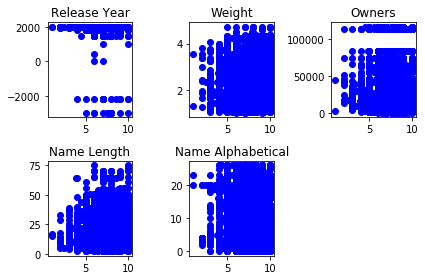

In [3]:
## generate scatterplots of the variables of interest versus rating
# breakout the needed columns from the larger dataset
to_plot = bgg_data[["Release Year", "Weight", "Owners", "Name Length", "Name Alphabetical"]]

# initialize a plot
fig = plt.figure()

# build subplots for each relationship
for i in range(len(to_plot.columns)):
    # set the plot's position in a 2 x 3 grid
    plt.subplot(2, 3, i + 1)
    
    # plot the column versus rating
    plt.plot(bgg_data["Rating"], to_plot[to_plot.columns[i]], 'bo')
    
    # title subplot by column name
    plt.title(to_plot.columns[i])

# show the plot
fig.tight_layout()

We immediately see a couple of issues to address.

First, there are a number of dramatic release year outliers. We might reasonably assume that user ratings for ancient games such as Chess or Go are driven by different factors than user ratings for games released in the "modern" board game era (~1990 to present). To this end, removing these observations from the dataset and reframing our hypotheses to cover just the modern era is a reasonable approach.

Second, the clear "bar" pattern along the rating axis indicates that the user ratings are perhaps closer to ordinal than continuous. Indeed, when we look at the distribution of user ratings, we find that the vast majority of ratings fall directly on an integer value. We have several options to address this. Most directly, we could round the observed user ratings to the nearest integer value proceed as if it is true ordinal data. Alternatively, we can further alter our hypothesis from considering individual user rating to considering the average user rating, the distribution of which is better behaved. I like the second approach better. The dataset was initially gathered in pursuit of an alternative hypothesis; we will treat it as observational data and filter out duplicates such that we have a single data point per game.

Implementing these changes, our hypothesis is now:
For board games released after 1990, the average user rating is correlated with the game's release year, weight, total owners, length of name, and place in alphabetical order.

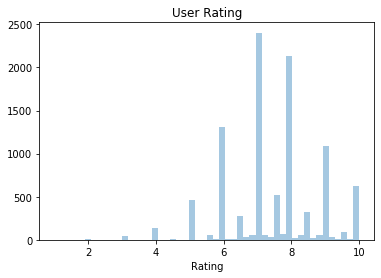

In [4]:
# plot a histogram of the ratings
sns.distplot(bgg_data["Rating"].astype(float), kde = False)
plt.title("User Rating")
plt.show()

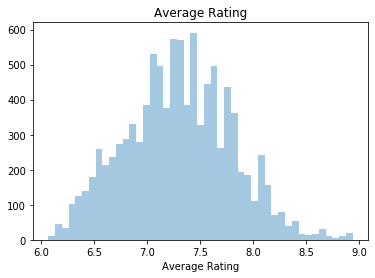

In [5]:
# plot a histogram of average rating
sns.distplot(bgg_data["Average Rating"], kde = False)
plt.title("Average Rating")
plt.show()

In [6]:
## implementing the changes proposed above
# remove observations with games released prior to 1990 from the dataset
bgg_1990 = bgg_data[bgg_data["Release Year"] >= 1990]

# sort out duplicate rows using Name as the key value
bgg_1990 = bgg_1990.drop_duplicates(subset = "Name")

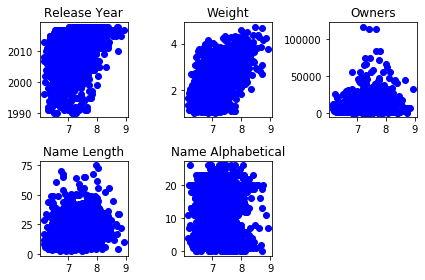

In [7]:
## generate new scatterplots as above with the modified dataset
## now plotting delta rating versus the explanatory interest
# breakout the needed columns from the larger dataset
to_plot = bgg_1990[["Release Year", "Weight", "Owners", "Name Length", "Name Alphabetical"]]

# initialize a plot
fig = plt.figure()

# build subplots for each relationship
for i in range(len(to_plot.columns)):
    # set the subplot's position in a 2 x 3 grid
    plt.subplot(2, 3, i + 1)
    
    # plot the column versus rating
    plt.plot(bgg_1990["Average Rating"], to_plot[to_plot.columns[i]], 'bo')
    
    # title subplot by column name
    plt.title(to_plot.columns[i])

# show the plot
fig.tight_layout()

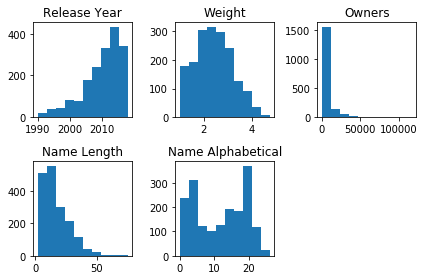

In [8]:
## plot distributions for the explanatory variables
# breakout the needed columns from the larger dataset
to_plot = bgg_1990[["Release Year", "Weight", "Owners", "Name Length", "Name Alphabetical"]]

# initialize a plot
fig = plt.figure()

# build subplots for each relationship
for i in range(len(to_plot.columns)):
    # set the subplot's position in a 2 x 3 grid
    plt.subplot(2, 3, i + 1)
    
    # plot the column versus rating
    plt.hist(to_plot[to_plot.columns[i]])
    
    # title subplot by column name
    plt.title(to_plot.columns[i])
    
# show the plot
fig.tight_layout()

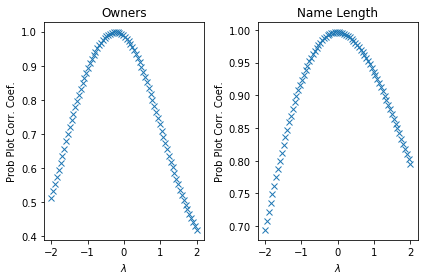

In [9]:
# Box-Cox plot of Owners and Name Length
fig = plt.figure()

# add subplots
ax1 = fig.add_subplot(1, 2, 1)
stats.boxcox_normplot(bgg_1990["Owners"], -2, 2, plot = ax1)
ax1.title.set_text("Owners")

ax2 = fig.add_subplot(1, 2, 2)
stats.boxcox_normplot(bgg_1990["Name Length"], -2, 2, plot = ax2)
ax2.title.set_text("Name Length")

# display the figure
fig.tight_layout()

A log transform looks reasonable for both. The other variables look relatively well behaved in terms of outliers.

We will transform Release Year and Registration Year from the actual year number into years since 1990 (start of dataset) and years since 2000 (start of BGG) to place the coefficients on a more reasonable scale.

In [10]:
# log transform Owners and name length
bgg_1990["log Owners"] = bgg_1990["Owners"].apply(math.log)
bgg_1990["log Name Length"] = bgg_1990["Name Length"].apply(math.log)

# transform years
bgg_1990["Delta Release"] = bgg_1990["Release Year"].apply(lambda x: x - 1990)
bgg_1990["Delta Registration"] = bgg_1990["Registration Year"].apply(lambda x: x - 2000)

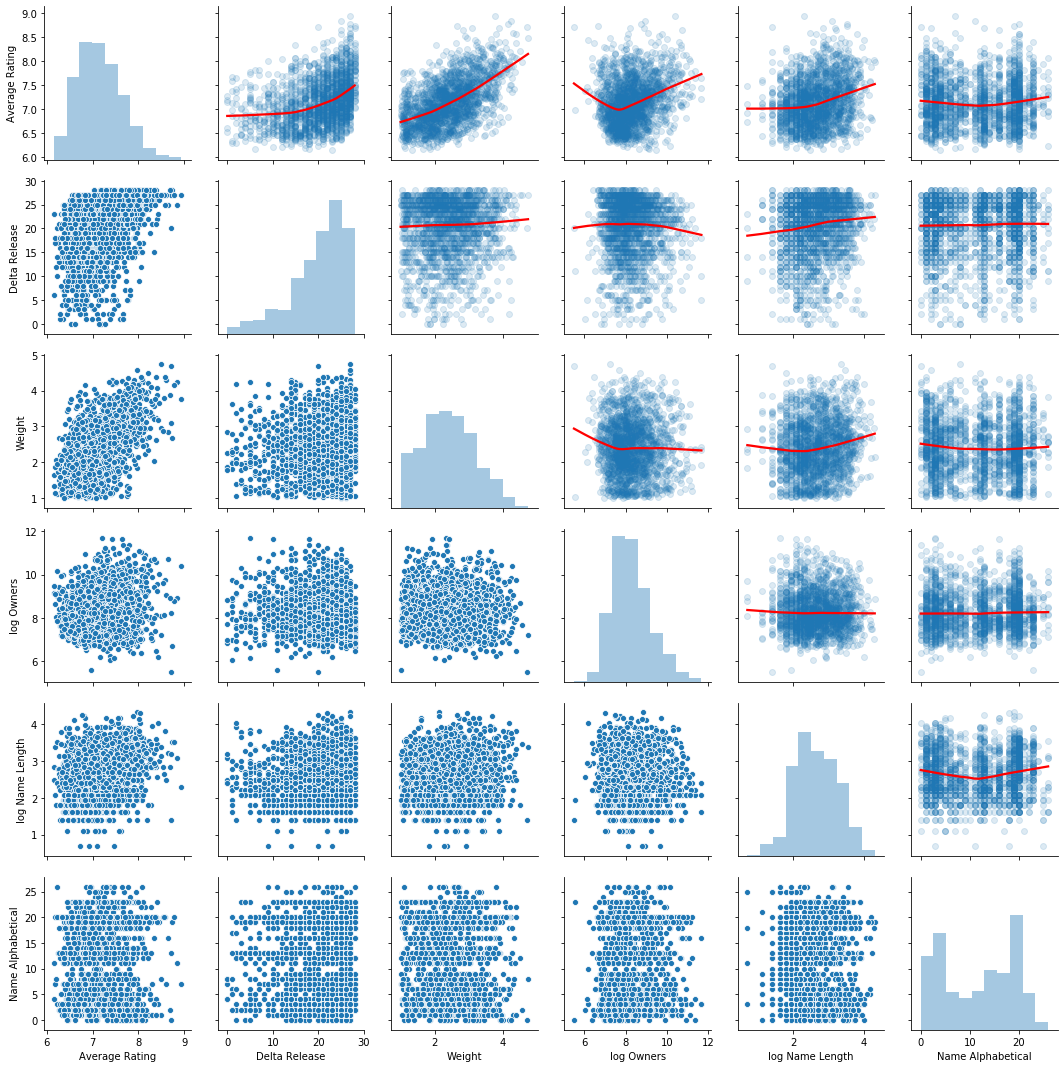

In [11]:
## pairs plot
# breakout the needed columns from the larger dataset
to_plot = bgg_1990[["Average Rating", "Delta Release", "Weight", "log Owners", "log Name Length", "Name Alphabetical"]]

# generate a pairs plot
pairs = sns.PairGrid(to_plot)
pairs = pairs.map_upper(sns.regplot, lowess = True, scatter_kws = {"alpha": 0.15}, line_kws = {"color": "red"})
pairs = pairs.map_diag(sns.distplot, kde = False, bins = 10)
pairs = pairs.map_lower(sns.scatterplot)

# show plot
plt.show()

Several variables, particularly log owners, looks to perhaps have a non-linear relationship with delta rating. We will test higher order terms after fitting the most basic model.

In [12]:
## fit an ols linear model for the relationship between delta rating and the other variables
# subset the full dataset
to_fit = bgg_1990[["Delta Release", "Weight", "log Owners", "log Name Length", "Name Alphabetical"]]

# format the variables into arrays, add a constant for the intercept term
X = to_fit.as_matrix()
X = sm.add_constant(X)
Y = bgg_1990["Average Rating"].as_matrix()

# fit the model, run t-tests on the coefficients
model = sm.OLS(Y, X).fit()
results = model.t_test(np.identity(X.shape[1]), use_t = True)

# output a coefficient summary
results.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
c0,4.5629,0.089,51.098,0.000,4.388,4.738
c1,0.0236,0.001,17.369,0.000,0.021,0.026
c2,0.3338,0.011,30.616,0.000,0.312,0.355
c3,0.1246,0.009,14.187,0.000,0.107,0.142
c4,0.0998,0.014,7.389,0.000,0.073,0.126
c5,0.0010,0.001,0.931,0.352,-0.001,0.003


**Checking modeling assumptions.**

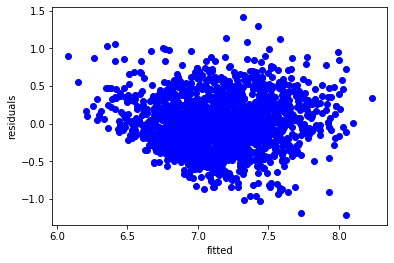

In [13]:
# plot residuals versus fitted values
plt.plot(model.fittedvalues, model.resid, 'bo')
plt.xlabel("fitted")
plt.ylabel("residuals")

plt.show()

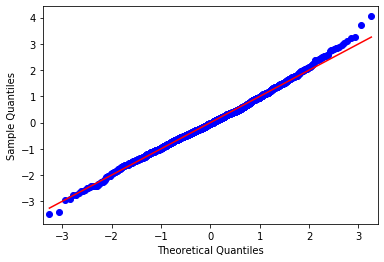

In [14]:
# Q-Q plot of standardized residuals
fig = ProbPlot(model.resid / np.std(model.resid, ddof = 1)).qqplot(line = "s")

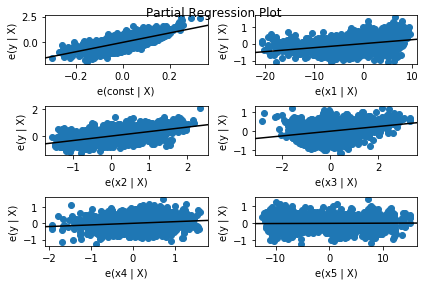

In [15]:
fig = sm.graphics.plot_partregress_grid(model)

In [16]:
## refit the model adding quadratic terms
# subset the full dataset
to_fit = bgg_1990[["Delta Release", "Weight", "log Owners", "log Name Length", "Name Alphabetical"]]

# add quadratic terms
to_fit = pd.concat([to_fit, to_fit.apply(lambda x: x**2)], axis = 1)

# format the variables into arrays, add a constant for the intercept termX = to_fit.as_matrix()
X = to_fit.as_matrix()
X = sm.add_constant(X)
Y = bgg_1990["Average Rating"].as_matrix()

# fit the model, run t-tests on the coefficients
model2 = sm.OLS(Y, X).fit()
results = model2.t_test(np.identity(X.shape[1]), use_t = True)

# output a coefficient summary
results.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
c0,10.4254,0.479,21.772,0.000,9.486,11.365
c1,-0.0519,0.006,-8.915,0.000,-0.063,-0.040
c2,0.0821,0.056,1.479,0.139,-0.027,0.191
c3,-1.0059,0.108,-9.332,0.000,-1.217,-0.795
c4,-0.0904,0.085,-1.057,0.291,-0.258,0.077
c5,-0.0127,0.004,-2.893,0.004,-0.021,-0.004
c6,0.0022,0.000,13.405,0.000,0.002,0.003
c7,0.0496,0.011,4.559,0.000,0.028,0.071
c8,0.0663,0.006,10.585,0.000,0.054,0.079
c9,0.0353,0.016,2.214,0.027,0.004,0.067


Release date and log owners appear to have a non-linear component to relationship with average rating with a signficant magnitude. We will add in the quadratic term.

In [17]:
## refit the model adding (Release Date)**2 log(Owners)^2
# subset the full dataset
to_fit = bgg_1990[["Delta Release", "Weight", "log Owners", "log Name Length", "Name Alphabetical"]]

# add log(Owners)^2
to_fit = pd.concat([to_fit, to_fit[["Delta Release", "log Owners"]].apply(lambda x: x**2)], axis = 1)

# format the variables into arrays, add a constant for the intercept termX = to_fit.as_matrix()
X = to_fit.as_matrix()
X = sm.add_constant(X)
Y = bgg_1990["Average Rating"].as_matrix()

# fit the model, run t-tests on the coefficients
model3 = sm.OLS(Y, X).fit()
results = model3.t_test(np.identity(X.shape[1]), use_t = True)

# output a coefficient summary
results.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
c0,9.9069,0.466,21.247,0.000,8.992,10.821
c1,-0.0514,0.006,-8.759,0.000,-0.063,-0.040
c2,0.3348,0.010,33.007,0.000,0.315,0.355
c3,-1.0230,0.109,-9.407,0.000,-1.236,-0.810
c4,0.1000,0.013,7.970,0.000,0.075,0.125
c5,0.0015,0.001,1.444,0.149,-0.001,0.004
c6,0.0022,0.000,13.227,0.000,0.002,0.003
c7,0.0673,0.006,10.658,0.000,0.055,0.080


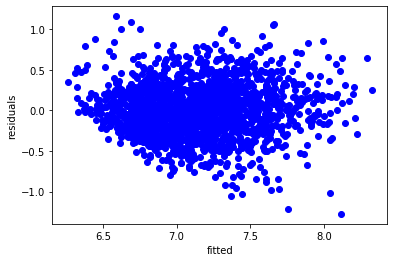

In [19]:
# plot residuals versus fitted values
plt.plot(model3.fittedvalues, model3.resid, 'bo')
plt.xlabel("fitted")
plt.ylabel("residuals")

plt.show()

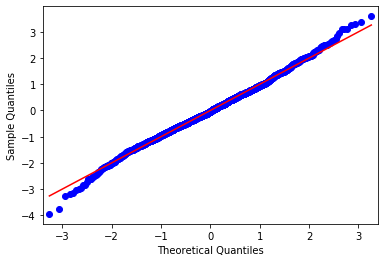

In [20]:
# Q-Q plot of standardized residuals
fig = ProbPlot(model3.resid/np.std(model3.resid, ddof = 1)).qqplot(line = "s")

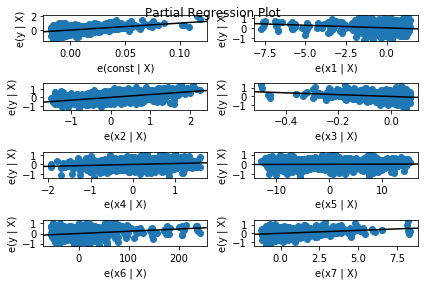

In [21]:
# partial regression plots
fig = sm.graphics.plot_partregress_grid(model3)

The distribution of residuals appears to deviate from normality with some broadening of the distribution tails. We will use robust regression as a means of decreasing these observations' effect on the coefficents without throwing them out entirely.

In [22]:
## refit the model using robust regression with a biweight weighting function
# subset the full dataset
to_fit = bgg_1990[["Delta Release", "Weight", "log Owners", "log Name Length", "Name Alphabetical"]]

# add log(Owners)^2
to_fit = pd.concat([to_fit, to_fit[["Delta Release", "log Owners"]].apply(lambda x: x**2)], axis = 1)

# format the variables into arrays, add a constant for the intercept termX = to_fit.as_matrix()
X = to_fit.as_matrix()
X = sm.add_constant(X)
Y = bgg_1990["Average Rating"].as_matrix()

# fit the model, run t-tests on the coefficients
model_robust = sm.RLM(Y, X, M = sm.robust.norms.TukeyBiweight()).fit()
results = model_robust.t_test(np.identity(X.shape[1]), use_t = True)

# output a coefficient summary
results.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
c0,9.3689,0.462,20.270,0.000,8.462,10.275
c1,-0.0567,0.006,-9.744,0.000,-0.068,-0.045
c2,0.3461,0.010,34.422,0.000,0.326,0.366
c3,-0.8995,0.108,-8.345,0.000,-1.111,-0.688
c4,0.0899,0.012,7.230,0.000,0.066,0.114
c5,0.0018,0.001,1.768,0.077,-0.000,0.004
c6,0.0024,0.000,14.275,0.000,0.002,0.003
c7,0.0608,0.006,9.706,0.000,0.048,0.073


Adjusting for the seven comparisons gives a significance threhold of 0.007.

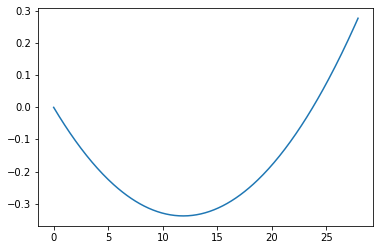

In [23]:
## release date coefficient plot
# define a range of x values
x1 = np.arange(bgg_1990["Delta Release"].min(), bgg_1990["Delta Release"].max(), 0.1)

# calculate y values
y1 = -0.057 * x1 + 0.0024 * x1**2

# generate plot
plt.plot(x1, y1)
plt.show()

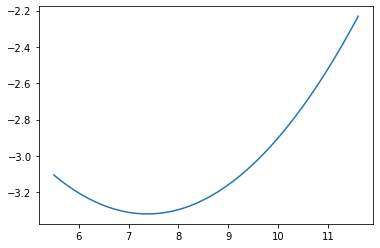

In [24]:
## owners coefficient plot
# define a range of x values
x2 = np.arange(bgg_1990["log Owners"].min(), bgg_1990["log Owners"].max(), 0.1)

# calculate y values
y2 = -0.90 * x2 + 0.061 * x2**2

# generate plot
plt.plot(x2, y2)
plt.show()